In [1]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator
import os
from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import StratifiedKFold
import tqdm
%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools
import pickle
#matrix inverse
from numpy.linalg import inv
import jj_basic_fn as JJ
from hyperparams import Hyperparams as hp
from patient import patient
import prep
import plot_funcs
import modules
#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7

col_rs = hp.col_rs
col_es = hp.col_es
col_le = hp.col_le
random_state = 42


/Users/hp/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hp/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [28]:
# [p241,p226] = modules.build_patients(-2, 90)
# pat_list = [p241,p226]
#p241 = modules.build_patients(241, 90)
#p231 = modules.build_patients(231, 90)
# p231, p222_1, p222_2, p229 = modules.build_patients(-1,90, if_weekly = 1)
# pat_list = [p231, p222_1, p222_2, p229]
# for pat in pat_list:
#     JJ.save_object(pat, '../patients/' + pat.id +'.p')
p231, p222_1, p222_2, p241 = modules.build_patients(-3,90)
pat_list = [p231, p222_1, p222_2, p241]

/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [48]:
num_all = np.array(list(pat.features.groupby('epoch')['filename'].count()))
num_test = np.array(list(X_test.groupby('epoch')['filename'].count()))
num_test/num_all

array([0.21052632, 0.19298246, 0.20689655, 0.20689655, 0.2       ,
       0.2       , 0.20754717, 0.20408163, 0.21052632, 0.19298246,
       0.19642857])

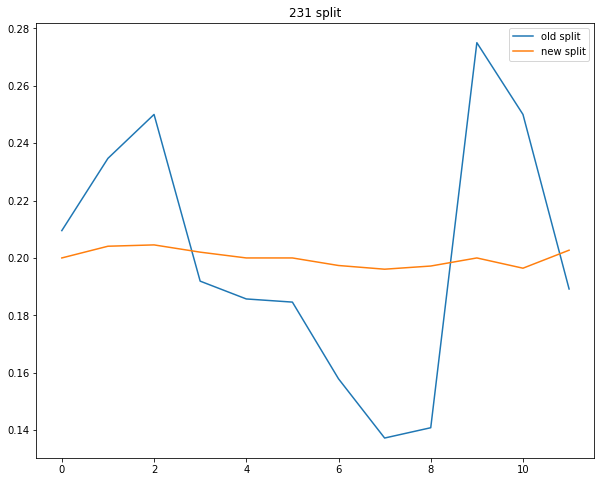

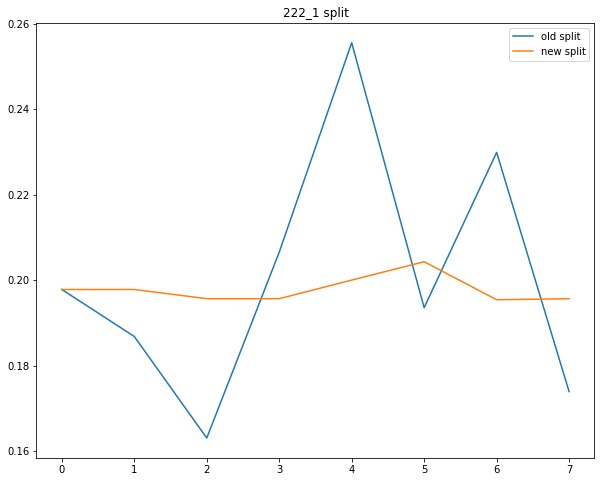

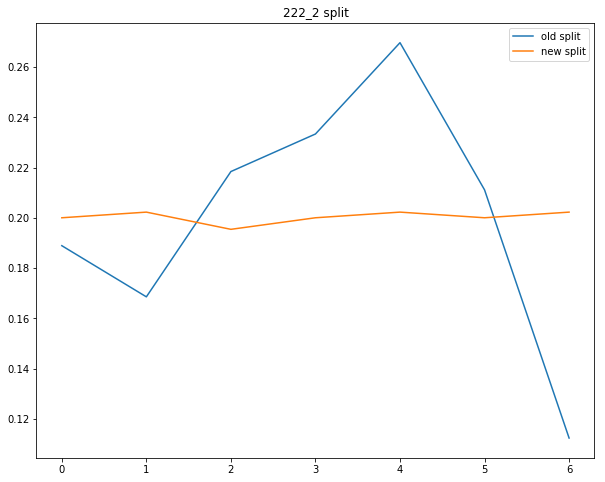

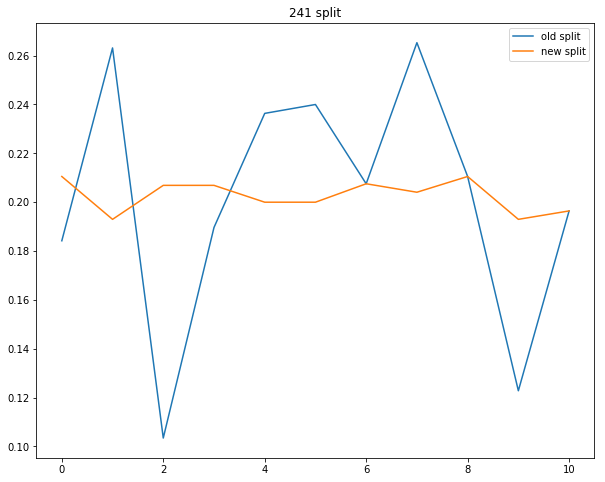

In [52]:
for pat in pat_list:
    num_all = np.array(list(pat.features.groupby('epoch')['filename'].count()))
    X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_split = -1)
    num_test = np.array(list(X_test.groupby('epoch')['filename'].count()))
    plt.plot(num_test/num_all, label = 'old split')
    X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_split = -2)
    num_test = np.array(list(X_test.groupby('epoch')['filename'].count()))
    plt.plot(num_test/num_all, label = 'new split')
    plt.title(pat.id + ' split')
    plt.legend()
    plt.show()    

In [26]:
X_test

,filename,region_start_time,long_epi,sleep,delta1,delta2,delta3,delta4,theta1,theta2,theta3,theta4,alpha1,alpha2,alpha3,alpha4,beta1,beta2,beta3,beta4,lowgamma1,lowgamma2,lowgamma3,lowgamma4,highgamma1,highgamma2,highgamma3,highgamma4,all1,all2,all3,all4,i12,i34,epoch,label,id,if_stimulated
1382,1.312503e+17,2016-11-30 14:54:19.000022400,0.0,0.0,55.442401,166.718065,41.607668,89.415658,133.171901,358.465803,102.972159,236.751074,40.140638,150.483014,100.146668,172.207340,43.025706,168.537063,107.632499,218.808792,14.382904,98.946030,65.238420,107.941227,9.492269,27.749090,23.685630,35.977657,294.073607,969.344983,440.386314,858.443110,0.0,0.0,1,False,222_2,False
1687,1.313392e+17,2017-03-13 16:58:03.000028800,0.0,0.0,52.202044,151.618125,36.895988,71.835383,170.665099,316.926318,69.074458,184.861921,39.873729,153.584048,79.238069,152.199727,62.479202,178.726010,130.970161,216.006518,15.188533,90.059601,75.492003,89.587354,10.674327,25.035549,30.724681,31.403811,351.570580,916.924281,421.227060,750.810537,0.0,0.0,4,True,222_2,False
1859,1.313894e+17,2017-05-10 03:59:01.999968000,0.0,1.0,55.083269,138.152395,80.151482,160.392145,59.403131,174.098917,180.777105,335.343622,49.696085,131.763230,144.056544,184.434766,44.199023,171.537940,142.943396,160.136965,12.819581,68.979770,35.470378,49.051578,8.946198,18.740475,19.135446,20.763874,226.735121,700.117960,601.126747,905.968162,0.0,0.0,6,True,222_2,False
1334,1.312365e+17,2016-11-14 14:56:53.999980800,0.0,0.0,46.921248,170.008185,28.972537,84.610563,107.038072,356.884020,88.313024,193.908213,31.742252,133.698508,78.532454,188.511878,42.270351,160.686759,106.975448,218.018741,13.125022,97.564151,62.627265,96.528853,9.438152,27.628454,21.621531,33.329026,250.163850,943.989817,386.419389,812.142833,0.0,0.0,0,False,222_2,False
1643,1.313272e+17,2017-02-26 20:47:12.999984000,0.0,0.0,34.036687,119.092198,22.959897,52.701527,55.367902,296.623211,73.406263,193.451173,30.849907,135.246800,80.646502,167.657938,54.463082,157.075156,188.928527,215.931729,12.859548,95.763065,74.489697,98.707678,9.508510,26.448851,21.665985,34.190852,196.243800,828.087187,461.676379,760.886925,0.0,0.0,4,True,222_2,False
1564,1.313039e+17,2017-01-31 15:51:26.000035200,0.0,0.0,58.030722,134.684099,25.961817,76.936000,112.277508,379.318143,85.429906,199.491250,39.101117,101.397227,96.109014,202.412621,47.706718,147.380853,184.065643,212.448345,13.449871,75.349319,61.822398,96.903901,9.507000,24.077624,20.266654,32.076668,278.952411,858.411522,472.844519,818.227215,0.0,0.0,3,False,222_2,False
1445,1.312693e+17,2016-12-21 20:58:08.000025600,0.0,0.0,32.301529,96.107305,19.768314,109.554655,53.676627,212.548272,210.472927,219.692287,25.477841,99.124717,121.092112,131.827711,41.626138,140.898407,202.846514,165.723187,12.772597,75.535872,37.899163,70.723211,9.170875,23.877924,13.485721,29.263292,174.490307,645.028991,604.766699,724.629044,0.0,0.0,1,False,222_2,False
1319,1.312321e+17,2016-11-09 14:57:47.999980800,0.0,0.0,50.502099,173.181610,42.628113,106.492271,131.684487,399.285643,81.201701,248.645016,35.436027,99.497745,59.363447,190.394916,48.551052,141.679643,113.088083,230.565568,14.422762,97.545412,81.342652,97.959029,9.677132,26.696331,34.194562,33.747065,289.654183,934.003372,410.301472,906.553874,0.0,0.0,0,False,222_2,False
1760,1.313608e+17,2017-04-07 04:53:56.999961600,0.0,1.0,85.882308,387.852578,115.460688,280.055881,101.378235,319.495000,192.537699,429.466930,83.952956,206.514512,96.217094,208.118268,77.711259,213.946157,148.526441,162.951555,13.308560,100.905092,67.866591,61.983064,9.529735,23.477387,32.684400,27.675872,370.094066,1241.156969,649.555052,1165.800059,0.0,1.0,5,False,222_2,False
1697,1.313428e+17,2017-03-17 04:57:26.000006400,0.0,1.0,61.815749,258.549102,77.423036,161.274288,76.200850,306.054055,143.594359,318.324912,46.727449,174.109161,104.755855,146.816473,48.666968,222.205035,144.976727,171.751232,12.986224,109.406906,56.654421,75.818270,9.326854,27.201989,28.944067,28.252794,254.31557

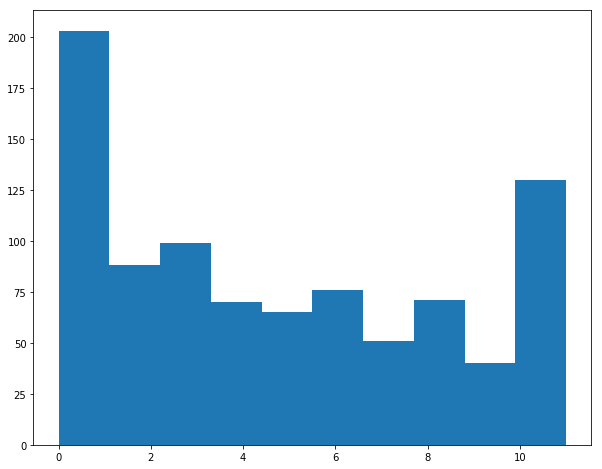

In [118]:
label = '_w'

p231 = pickle.load(open(hp.prepath_pat + '231_trained' + label + '.p', "rb" ))
p222_1 = pickle.load(open(hp.prepath_pat + '222_1_trained' + label + '.p', "rb" ))
p222_2 = pickle.load(open(hp.prepath_pat + '222_2_trained' + label + '.p', "rb" ))
p241 = pickle.load(open(hp.prepath_pat + '241_trained' + label + '.p', "rb" ))
pats = [p231, p222_1, p222_2, p241]

# for pat in pats:
#     print('Patient ', pat.id)
#     X_train, X_test, y_train, y_test = pat.X_train, pat.X_test, pat.y_train, pat.y_test
#     JJ.scores_estimators(X_test, y_test, pat= pat, if_save = 0)
#     plot_funcs.plot_roc_all(X_test, y_test, pat =pat, if_save = 0)

In [125]:
p231.X_train.shape

(722, 24)

In [114]:
X_train, X_test, y_train, y_test = modules.get_ml_data(p231, split = -1)

(714, 38)
(179, 38)
(893, 38)


In [112]:
X_test = X.groupby('epoch', group_keys=False).apply(lambda x: x.sample(frac = 0.2, random_state = random_state))
train_idx = [a for a in list(X.index) if a not in list(X_test.index)]
X_train = X.loc[train_idx]
print(X_train.shape)
print(X_test.shape)
print(X.shape)


y_train = X_train.loc[:,'label']
y_test = X_test.loc[:,'label']

drop_list = ['label', 'region_start_time', 'epoch', 'if_stimulated', 'filename', 'id',]
if if_remove_delta:
    drop_list += ['delta1',  'delta2',  'delta3', 'delta4']
if if_remove_icd:
    drop_list.append('i12')
    drop_list.append('i34')
if if_remove_sleep:
    if 'sleep' in dat.columns:
        drop_list.append('sleep')
if if_remove_le:
    if 'long_epi' in dat.columns:
        drop_list.append('long_epi')
X_train = np.array(X_train.drop(drop_list, axis = 1, inplace = False))
X_test = np.array(X_test.drop(drop_list, axis = 1, inplace = False))

print(X_train)
y=y.astype('int')

if if_scaler:
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)    

(714, 38)
(179, 38)
(893, 38)
[[ 83.02585486  49.76639023 101.68593566 ... 374.85167496 431.14456933
  200.21298543]
 [ 78.43353809  52.02397876 110.20305142 ... 386.78074496 504.75266929
  212.88359187]
 [111.81421911 114.2538049  110.93608164 ... 619.70509721 461.33567216
  202.95393524]
 ...
 [ 89.96687869  90.94038614  96.88758053 ... 512.57280887 468.42539585
  194.6346921 ]
 [225.67023784 264.01521266 207.82988984 ... 957.46209822 744.38448506
  552.02751012]
 [113.61508112  76.85967696 149.85058018 ... 450.54621368 534.26057606
  231.5109682 ]]


NameError: name 'scaler' is not defined

In [106]:
X

,theta1,theta2,theta3,theta4,alpha1,alpha2,alpha3,alpha4,beta1,beta2,beta3,beta4,lowgamma1,lowgamma2,lowgamma3,lowgamma4,highgamma1,highgamma2,highgamma3,highgamma4,all1,all2,all3,all4,epoch
647,77.653426,73.585284,132.283194,41.393056,76.774523,83.716009,73.781896,24.715429,158.709932,195.014768,132.185618,57.815951,66.921943,84.626163,59.516749,41.280686,17.842459,19.848230,17.768902,15.825719,449.080826,497.912560,583.423582,228.331494,0
648,83.025855,49.766390,101.685936,43.323707,52.038473,63.795443,55.284608,19.814494,135.766837,143.574827,103.785208,42.320166,66.032288,64.156730,52.980774,39.005670,18.193194,18.552144,19.051299,15.535918,420.025064,374.851675,431.144569,200.212985,0
649,78.433538,52.023979,110.203051,36.999955,64.644898,55.724151,58.688134,19.871226,181.487332,155.427435,121.713626,47.794228,72.383902,61.297536,63.108861,41.514227,20.093607,19.112256,21.323889,16.489723,514.946178,386.780745,504.752669,212.883592,0
650,111.814219,114.253805,110.936082,41.216232,105.378780,114.072113,62.648212,27.869914,187.564442,220.525742,115.320875,53.176903,67.959740,67.252669,51.975569,33.809532,18.470845,20.585696,17.197160,13.557635,619.553782,619.705097,461.335672,202.953935,0
651,79.233067,64.724569,102.978850,40.099788,50.436315,75.311729,57.604117,19.613029,152.275433,146.887291,119.058054,44.874632,58.494189,54.774480,51.623943,35.571129,17.948774,17.112005,18.905673,14.801637,449.277355,418.643967,507.236063,213.607815,0
652,94.976730,44.356892,127.877129,37.657951,60.909213,50.234004,56.588664,20.412051,175.384442,139.574490,129.467766,43.214728,72.943196,67.520685,59.434903,40.154272,19.055256,19.792319,21.209860,16.168228,538.850676,375.030443,544.170195,214.113030,0
653,89.035278,65.329579,116.948584,39.398970,53.993892,60.320291,59.247493,21.095735,164.874577,137.077698,124.463671,43.715393,72.642027,65.786504,58.806123,38.956958,19.665885,20.966004,21.826760,17.061921,488.830085,399.226190,526.187100,214.809479,0
654,95.763307,71.407570,122.993170,57.822330,67.209221,66.088375,63.251004,29.921334,166.247965,152.007860,113.562948,47.980650,64.437075,65.954881,50.772976,40.047462,18.549292,19.435048,18.441909,14.647193,493.822944,414.372099,487.273913,245.373050,0
655,305.556517,262.238440,397.426399,224.110307,138.953876,145.565883,211.420221,231.338610,177.562402,170.194289,253.711598,264.543956,50.122690,56.374755,64.771171,103.383557,18.156613,21.049244,17.841345,21.241607,1013.509263,908.738281,1280.147218,938.436500,0
656,98.074770,73.821734,160.924270,45.976279,56.985345,59.483602,57.492818,24.894696,152.543317,138.803821,114.986092,45.199388,59.410178,62.847114,48.996098,38.588562,17.512215,19.912663,17.567147,16.379624,455.327692,405.171813,540.379631,226.173082,0


In [82]:
sum(X_test.loc[:,'epoch'] == 2)

18

In [83]:
sum(X.loc[:,'epoch'] == 2)

88

In [97]:
X_train = X.loc[train_idx]
print(X_train.shape)
print(X_test.shape)
print(X.shape)


(714, 25)
(179, 25)
(893, 25)


In [51]:

df = pd.DataFrame(dict(
        A=[1, 1, 1, 2, 2, 2, 2, 3, 4, 4],
        B=range(10)
    ))

df.groupby('A', group_keys=False).apply(lambda x: x.sample(frac = 0.6, random_state = random_state))

,A,B
0,1,0
1,1,1
4,2,4
6,2,6
7,3,7
9,4,9


In [15]:
df

,A,B
0,1,0
1,1,1
2,1,2
3,2,3
4,2,4
5,2,5
6,2,6
7,3,7
8,4,8
9,4,9
